<a href="https://colab.research.google.com/github/Lihini827/speech-emotion-hybridLSTM-RNn-gradcam/blob/main/(4)Transformers_(DeiT).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import DeiTFeatureExtractor, DeiTForImageClassification

# Define dataset paths
data_dir = "/content/drive/MyDrive/speech emotion/Melspectro"

# Define transformations for data preprocessing and augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create datasets and data loaders
train_dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=train_transform)
valid_dataset = datasets.ImageFolder(os.path.join(data_dir, "val"), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, "test"), transform=val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Load the pre-trained DeiT model
model_name = "facebook/deit-base-distilled-patch16-224"
feature_extractor = DeiTFeatureExtractor(model_name)
model = DeiTForImageClassification.from_pretrained(model_name, num_labels=len(train_dataset.classes))

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)  # Adjust learning rate

# Learning rate scheduler with warm-up
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, total_steps=len(train_loader) * 20)

# Training loop
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

best_validation_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    val_running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        val_running_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        validation_accuracy = 100 * correct / total

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total

        # Save the model if validation accuracy improved
        if validation_accuracy > best_validation_accuracy:
            best_validation_accuracy = validation_accuracy
            torch.save(model.state_dict(), "best_model.pth")

    print(f"Epoch [{epoch + 1}/{num_epochs}] "
          f"Validation Loss: {val_running_loss / len(train_loader):.4f} "
        f"Training Loss: {running_loss / len(train_loader):.4f} "

          f"Validation Accuracy: {validation_accuracy:.2f}%"
         f"Training Accuracy: {train_accuracy:.2f}%")

    # Adjust learning rate
    scheduler.step()

# Load the best model for testing
model.load_state_dict(torch.load("best_model.pth"))

# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)
        test_total +=labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

/usr/local/lib/python3.10/dist-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch [1/20] Validation Loss: 0.1013 Training Loss: 1.0049 Validation Accuracy: 90.36%Training Accuracy: 68.21%
Epoch [2/20] Validation Loss: 0.0738 Training Loss: 0.5390 Validation Accuracy: 95.71%Training Accuracy: 81.90%
Epoch [3/20] Validation Loss: 0.0072 Training Loss: 0.3467 Validation Accuracy: 100.00%Training Accuracy: 86.85%
Epoch [4/20] Validation Loss: 0.0032 Training Loss: 0.2420 Validation Accuracy: 100.00%Training Accuracy: 93.80%
Epoch [5/20] Validation Loss: 0.0018 Training Loss: 0.2086 Validation Accuracy: 100.00%Training Accuracy: 91.80%
Epoch [6/20] Validation Loss: 0.0008 Training Loss: 0.1836 Validation Accuracy: 100.00%Training Accuracy: 94.29%
Epoch [7/20] Validation Loss: 0.0004 Training Loss: 0.1489 Validation Accuracy: 100.00%Training Accuracy: 92.82%
Epoch [8/20] Validation Loss: 0.0007 Training Loss: 0.1695 Validation Accuracy: 100.00%Training Accuracy: 93.31%
Epoch [9/20] Validation Loss: 0.0004 Training Loss: 0.1503 Validation Accuracy: 100.00%Training Ac

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


Classification Report:
              precision    recall  f1-score   support

       angry       1.00      1.00      1.00        82
     disgust       0.98      1.00      0.99        80
        fear       1.00      0.99      0.99        80
       happy       0.98      0.99      0.98        80
     neutral       1.00      1.00      1.00        81
         sad       1.00      1.00      1.00        80
    surprise       0.99      0.96      0.97        80

    accuracy                           0.99       563
   macro avg       0.99      0.99      0.99       563
weighted avg       0.99      0.99      0.99       563



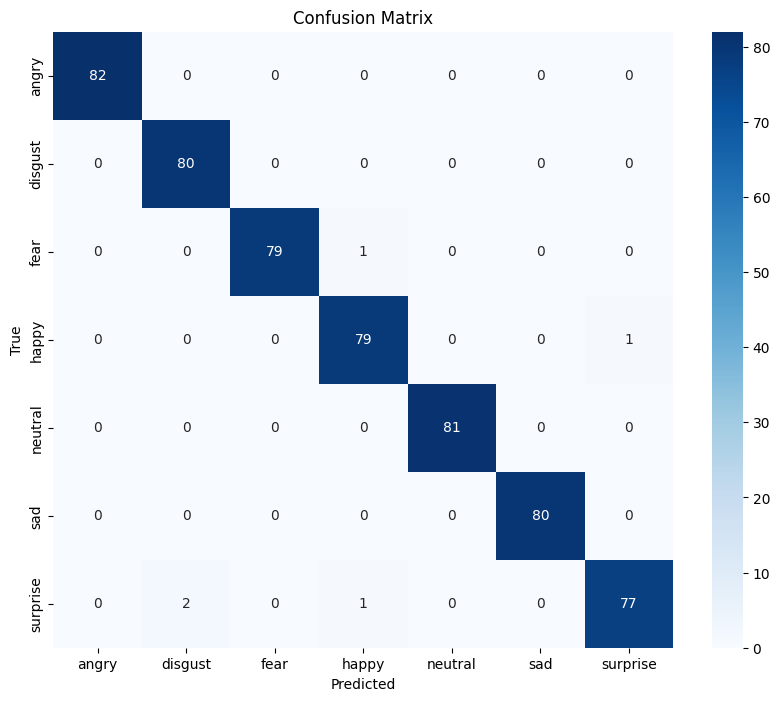

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
import seaborn as sns
# Lists to store predicted and true labels
all_predicted_labels = []
all_true_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.logits, 1)

        # Append predicted and true labels to the lists
        all_predicted_labels.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_true_labels, all_predicted_labels, target_names=test_dataset.classes))

# Confusion matrix
cm = confusion_matrix(all_true_labels, all_predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
